# Comparing output to observations

Sources: 
- DelftDashboard IHO stations (tide-only)
- https://github.com/Deltares/dfm_tools/blob/main/docs/notebooks/subset_retrieve_sealevel_observations.ipynb

In [2]:
import os
import glob
import matplotlib.pyplot as plt
import xarray as xr
import dfm_tools as dfmt

c:\Users\aleksand\AppData\Local\anaconda3\envs\dfm_tools_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## IHO tidal constituents

In [3]:
# IHO tidal data
datadir_iho = r'n:\Deltabox\Bulletin\leijnse\OET_Matlab\applications\DelftDashBoard\toolboxes\TideStations\data\iho.nc'
iho = xr.open_dataset(datadir_iho)
iho

<xarray.Dataset> Size: 5MB
Dimensions:     (component_string_length: 6, components: 125,
                 name_string_length: 20, stations: 4509,
                 idcode_string_length: 19)
Coordinates:
    components  (component_string_length, components) |S1 750B ...
    stations    (name_string_length, stations) |S1 90kB ...
Dimensions without coordinates: component_string_length, name_string_length,
                                idcode_string_length
Data variables:
    crs         int32 4B ...
    idcodes     (idcode_string_length, stations) |S1 86kB ...
    amplitude   (components, stations) float32 2MB ...
    phase       (components, stations) float32 2MB ...
    lon         (stations) float64 36kB ...
    lat         (stations) float64 36kB ...
Attributes:
    Conventions:     CF-1.4
    CF:featureType:  grid
    title:           IHO Tidal Stations
    institution:     IHO
    source:          IHO
    history:         created by Maarten van Ormondt (7-Mar-2011)
    references:      No reference material available
    comment:         no comment
    email:           Maarten.vanOrmondt@deltares.nl
    version:         1.0
    terms_for_use:   Use as you like
    disclaimer:      These data are made available in the hope that it will b...

In [4]:
# decode the list of stations
iho.stations.load()
list_stations = []
for ss in range(len(iho.lon)):
    tmp = iho.stations.values[:,ss]
    st = ''
    for ii in tmp:
        st += ii.decode('UTF-8')
    st = st.strip()
    list_stations.append(st)


In [5]:
# Find stations
id_beira = list_stations.index('BEIRA IHO')



## Observation stations

To get an overview of the largest publicly available global sealevel observation datasets, we use dfmt.ssh_catalog_subset() with the source argument. For IOC and GESLA3 we also subset to highlight where they add significantly to the global spatial spatial coverage.

In [6]:
gesla_catalog_gpd = dfmt.ssh_catalog_subset(source='gesla3') # requires p-drive connection or download yourself
ioc_catalog_gpd = dfmt.ssh_catalog_subset(source='ioc')
#cmems_list_gpd = dfmt.ssh_catalog_subset(source='cmems')
uhslc_json_rqds = dfmt.ssh_catalog_subset(source='uhslc-rqds')
uhslc_json_fast = dfmt.ssh_catalog_subset(source='uhslc-fast')
psmsl_gnssir_gpd = dfmt.ssh_catalog_subset(source='psmsl-gnssir')
#rwsddl_gpd = dfmt.ssh_catalog_subset(source='rwsddl')

# subsetting gesla
bool_ndays = gesla_catalog_gpd["time_ndays"] > 365
bool_country = gesla_catalog_gpd['country'].isin(['CAN','GRL'])
bool_contrib = gesla_catalog_gpd['contributor_abbreviated'].isin(['MEDS',"GLOSS"])
gesla_catalog_gpd_sel = gesla_catalog_gpd.loc[bool_country & bool_contrib & bool_ndays]

# subsetting ioc
bool_ndays = ioc_catalog_gpd["time_ndays"] > 365
bool_country = ioc_catalog_gpd['country'].isin(['RUS','IND']) #,'TUR','ISR','CYP','KRS','HRV','HEL'])
ioc_catalog_gpd_sel = ioc_catalog_gpd.loc[bool_ndays & bool_country]

>> reading coastlines: 3.78 sec
>> reading country borders: 0.08 sec


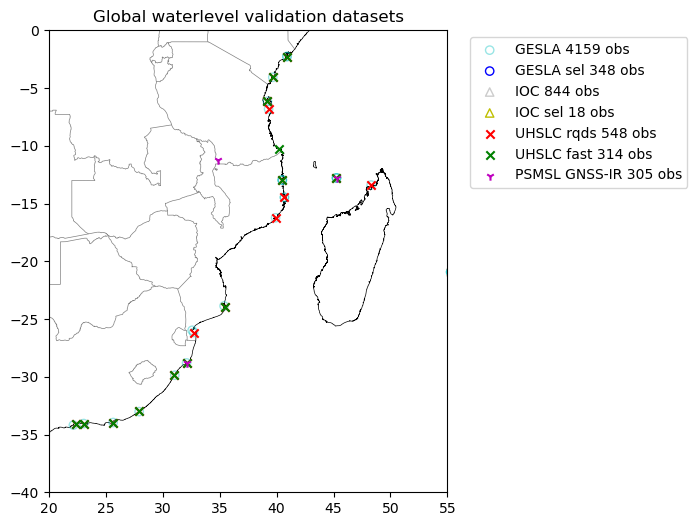

In [7]:
# plot stations
fig,ax = plt.subplots(figsize=(14,6))
gesla_catalog_gpd.geometry.plot(ax=ax, marker="o", color="c", facecolor="none", label=f"GESLA {len(gesla_catalog_gpd)} obs", alpha=0.4)
gesla_catalog_gpd_sel.geometry.plot(ax=ax, marker="o", color="b", facecolor="none", label=f"GESLA sel {len(gesla_catalog_gpd_sel)} obs")
ioc_catalog_gpd.geometry.plot(ax=ax, marker="^", color="grey", facecolor="none", label=f"IOC {len(ioc_catalog_gpd)} obs", alpha=0.4)
ioc_catalog_gpd_sel.geometry.plot(ax=ax, marker="^", color="y", facecolor="none", label=f"IOC sel {len(ioc_catalog_gpd_sel)} obs")
#cmems_list_gpd.geometry.plot(ax=ax, marker="+", color="g", label=f"CMEMS {len(cmems_list_gpd)} obs")
uhslc_json_rqds.geometry.plot(ax=ax, marker="x", color="r", label=f"UHSLC rqds {len(uhslc_json_rqds)} obs")
uhslc_json_fast.geometry.plot(ax=ax, marker="x", color="g", label=f"UHSLC fast {len(uhslc_json_fast)} obs")
psmsl_gnssir_gpd.geometry.plot(ax=ax, marker="1", color="m", label=f"PSMSL GNSS-IR {len(psmsl_gnssir_gpd)} obs")
#rwsddl_gpd.geometry.plot(ax=ax, marker="2", color="c", label=f"RWS DDL {len(rwsddl_gpd)} obs")


ax.set_ylim(-40,0)
ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
ax.set_title("Global waterlevel validation datasets")
ax.set_xlim(20,55)
dfmt.plot_coastlines(ax=ax, min_area=1000, linewidth=0.5, zorder=0)
dfmt.plot_borders(ax=ax, zorder=0)

Next, we will subset all sources in time and space by providing more arguments to dfmt.ssh_catalog_subset. The stations with data in this period and area are plotted.

retrieving psmsl-gnssir time extents for 2 stations: 1 2 
>> reading coastlines: 4.01 sec
>> reading country borders: 0.07 sec


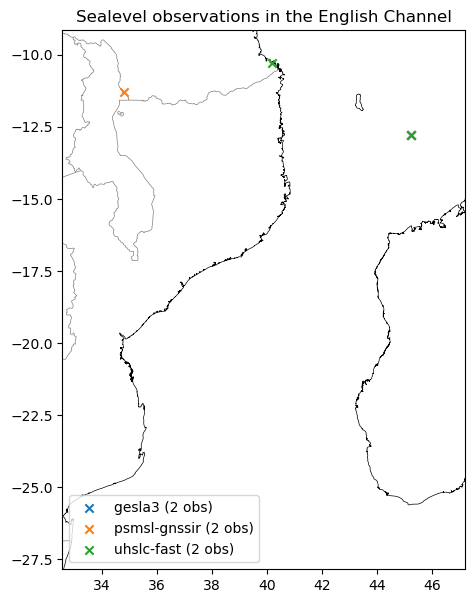

In [25]:
dir_output = "../results/sealevel_data_obs_subset"
os.makedirs(dir_output, exist_ok=True)

lon_min, lon_max, lat_min, lat_max = 32.55, 47.22, -27.84, -9.15 # mozambique  

time_min, time_max = '2019-03-01','2019-03-30'

subset_kwargs = dict(lon_min=lon_min, lon_max=lon_max, lat_min=lat_min, lat_max=lat_max, 
                     time_min=time_min, time_max=time_max)
gesla_catalog_gpd_sel = dfmt.ssh_catalog_subset(source='gesla3', **subset_kwargs)
ioc_catalog_gpd_sel = dfmt.ssh_catalog_subset(source='ioc', **subset_kwargs)
#cmems_list_gpd_sel = dfmt.ssh_catalog_subset(source='cmems', **subset_kwargs)
uhslc_json_rqds_sel = dfmt.ssh_catalog_subset(source='uhslc-rqds', **subset_kwargs)
uhslc_json_fast_sel = dfmt.ssh_catalog_subset(source='uhslc-fast', **subset_kwargs)
psmsl_gnssir_gpd_sel = dfmt.ssh_catalog_subset(source='psmsl-gnssir', **subset_kwargs)
# TODO: no time subsetting supported for rwsddl yet
for key in ["time_min", "time_max"]:
    subset_kwargs.pop(key)
#rwsddl_gpd_sel = dfmt.ssh_catalog_subset(source='rwsddl', **subset_kwargs)
#subset_gpd_list = [gesla_catalog_gpd_sel, ioc_catalog_gpd_sel,
#                  cmems_list_gpd_sel, psmsl_gnssir_gpd_sel,
#                  uhslc_json_rqds_sel, uhslc_json_fast_sel,
#                  rwsddl_gpd_sel]
subset_gpd_list = [gesla_catalog_gpd_sel, ioc_catalog_gpd_sel,
                   psmsl_gnssir_gpd_sel,
                  uhslc_json_rqds_sel, uhslc_json_fast_sel]

# plot stations
fig,ax = plt.subplots(figsize=(12,7))
for subset_gpd in subset_gpd_list:
    if subset_gpd.empty:
        continue
    source = subset_gpd.iloc[0]["source"]
    nstations = len(subset_gpd)
    subset_gpd.geometry.plot(ax=ax, marker="x", label=f"{source} ({nstations} obs)")
ax.legend(loc=3)
ax.set_title("Sealevel observations")
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)
dfmt.plot_coastlines(ax=ax, min_area=1000, linewidth=0.5, zorder=0)
dfmt.plot_borders(ax=ax, zorder=0)

This data is retrieved with dfmt.ssh_retrieve_data. Select the sources below.

In [26]:
# retrieve data (for all except gesla and ioc)
subset_gpd_list_retrieve = [gesla_catalog_gpd_sel,uhslc_json_fast_sel]
for subset_gpd in subset_gpd_list_retrieve:
    dfmt.ssh_retrieve_data(subset_gpd, dir_output,
                           time_min=time_min, time_max=time_max)

retrieving data for 2 gesla3 stations: 1 

c:\Users\aleksand\AppData\Local\anaconda3\envs\dfm_tools_env\Lib\site-packages\dfm_tools\observations.py:697: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  data = pd.read_csv(f, comment='#', delim_whitespace = True,
c:\Users\aleksand\AppData\Local\anaconda3\envs\dfm_tools_env\Lib\site-packages\dfm_tools\observations.py:697: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(f, comment='#', delim_whitespace = True,


2 

c:\Users\aleksand\AppData\Local\anaconda3\envs\dfm_tools_env\Lib\site-packages\dfm_tools\observations.py:697: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  data = pd.read_csv(f, comment='#', delim_whitespace = True,
c:\Users\aleksand\AppData\Local\anaconda3\envs\dfm_tools_env\Lib\site-packages\dfm_tools\observations.py:697: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(f, comment='#', delim_whitespace = True,



retrieving data for 2 uhslc-fast stations: 1 2 [NODATA] 


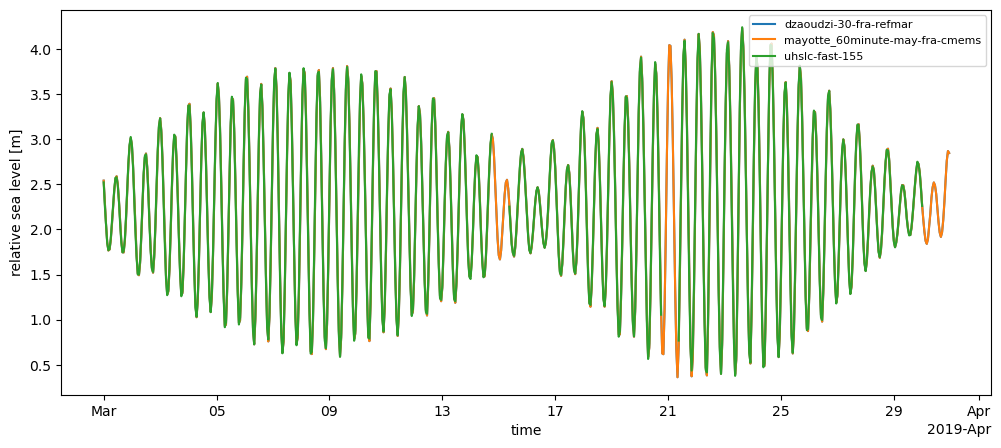

In [27]:
# plot the retrieved datasets
fig,ax = plt.subplots(figsize=(12,5))
file_list = glob.glob(os.path.join(dir_output, "*.nc"))
file_list.sort()
for file_nc in file_list:
    ds = xr.open_dataset(file_nc)
    station_name = os.path.basename(file_nc).strip(".nc")
    ds.waterlevel.plot(ax=ax, label=station_name)
    del ds
ax.legend(loc=1, fontsize=8)

In [28]:
file_list

['../results/sealevel_data_obs_subset\\dzaoudzi-30-fra-refmar.nc',
 '../results/sealevel_data_obs_subset\\mayotte_60minute-may-fra-cmems.nc',
 '../results/sealevel_data_obs_subset\\uhslc-fast-155.nc']

In [30]:
ds = xr.open_dataset(file_list[1])
ds

<xarray.Dataset> Size: 20kB
Dimensions:               (time: 720)
Coordinates:
  * time                  (time) datetime64[ns] 6kB 2019-03-01 ... 2019-03-30...
Data variables:
    waterlevel            (time) float32 3kB ...
    qc_flag               (time) float64 6kB ...
    use_flag              (time) float64 6kB ...
    station_name          |S64 64B ...
    station_id            |S64 64B ...
    station_x_coordinate  float64 8B ...
    station_y_coordinate  float64 8B ...
Attributes:
    station_name:         Mayotte_60minute
    station_id:           mayotte_60minute-may-fra-cmems
    station_name_unique:  mayotte_60minute-may-fra-cmems
    longitude:            45.258301
    latitude:             -12.78333
    country:              FRA
    source:               gesla3

In [33]:
print([ds.station_x_coordinate.values, '  ', ds.station_y_coordinate.values])

[array(45.258301), '  ', array(-12.78333)]


>> reading coastlines: 4.98 sec
>> reading coastlines: 1.50 sec


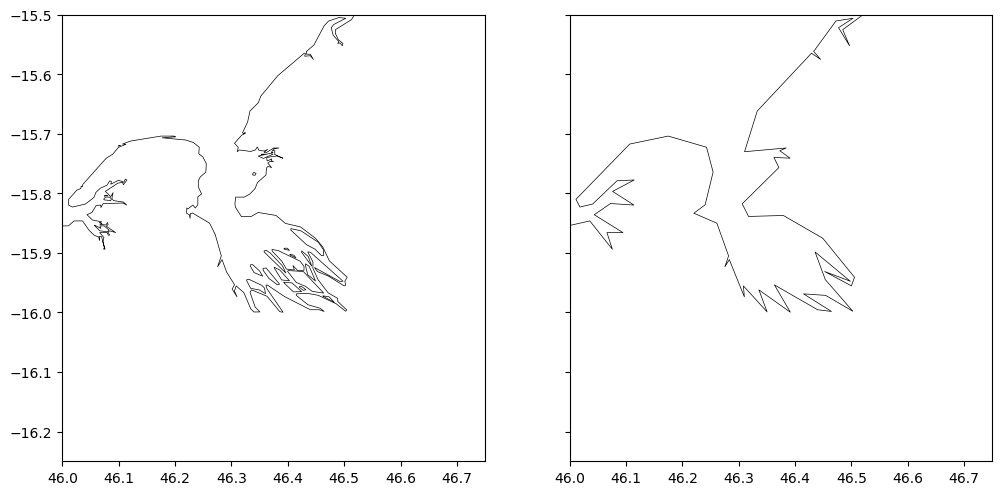

In [17]:
#fig = plt.subplots(figsize=(12,7),ncols=2)
fig, (ax1, ax2) = plt.subplots(figsize=(12,7),ncols=2, sharex=True,sharey=True)

ax1.set_xlim(46, 46.75)
ax1.set_ylim(-16.25,-15.50)
dfmt.plot_coastlines(ax=ax1, crs='EPSG:4326',res='h')
dfmt.plot_coastlines(ax=ax2, crs='EPSG:4326',res='i',min_area=50)

>> reading coastlines: 4.53 sec
>> reading coastlines: 1.00 sec


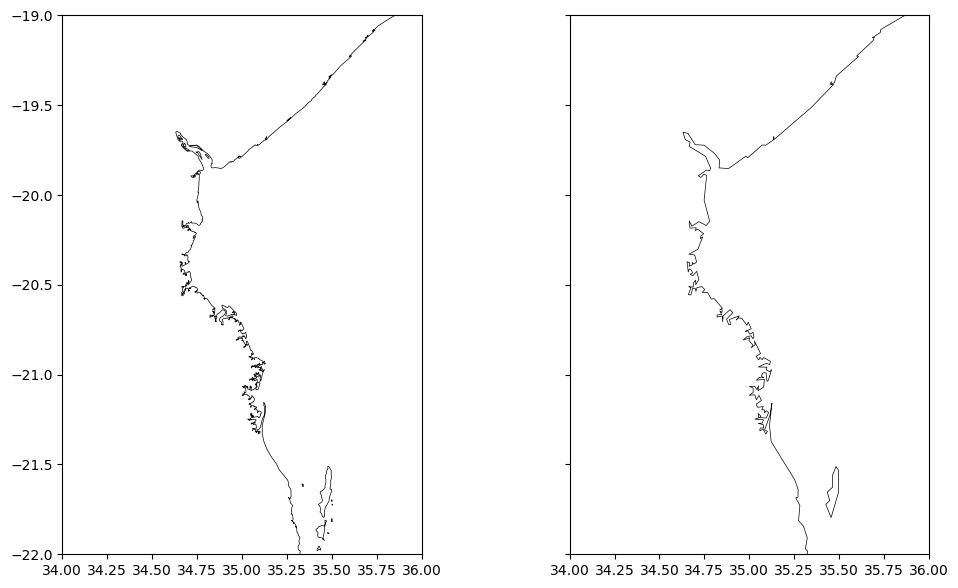

In [19]:
#fig = plt.subplots(figsize=(12,7),ncols=2)
fig, (ax1, ax2) = plt.subplots(figsize=(12,7),ncols=2, sharex=True,sharey=True)

ax1.set_xlim(34, 36)
ax1.set_ylim(-22,-19)
dfmt.plot_coastlines(ax=ax1, crs='EPSG:4326',res='h')
dfmt.plot_coastlines(ax=ax2, crs='EPSG:4326',res='i',min_area=50)